In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 98% 341M/346M [00:00<00:00, 629MB/s]
100% 346M/346M [00:00<00:00, 679MB/s]


In [3]:
import zipfile
zip_loc= zipfile.ZipFile('/content/intel-image-classification.zip','r')
zip_loc.extractall('/content')
zip_loc.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

### here 2d and 3d import of convulation and maxpooling layer depend upon the type of data being sent to input 2d is for image data , 3d is for 3d /temporal data like mri scan

In [6]:
# generators -> during the time of large datasets we use generators that pass the data to our model in batches
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/seg_train/seg_train',
    labels='inferred',
    label_mode='categorical',
    batch_size= 50,
    image_size=(128,128)   # reducing the size of image
)

validation_ds=keras.utils.image_dataset_from_directory(
    directory='/content/seg_test/seg_test',
    labels='inferred',
    label_mode='categorical',
    batch_size= 50,
    image_size=(128,128)
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [7]:
# now we need to normalize the pixel value
def process(image,label):
  image= tf.cast(image/255. ,tf.float32)
  return image,label

train_ds=train_ds.map(process)
validation_ds=validation_ds.map(process)

In [ ]:
!pip install keras-tuner

In [ ]:
# we will create our cnn  model while hyper parameter tuning
import kerastuner as kt

/tmp/ipython-input-2495082413.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
# first make a simple cnn architecture
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(126,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(36,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 126)            │    14,515,326 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 126)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 36)             │         4,572 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           222 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,614,264 (55.75 MB)

 Trainable params: 14,613,816 (55.75 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history= model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 44s 135ms/step - accuracy: 0.3300 - loss: 4.8626 - val_accuracy: 0.2500 - val_loss: 2.1704
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - accuracy: 0.3341 - loss: 1.6724 - val_accuracy: 0.3250 - val_loss: 1.5129
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.3702 - loss: 1.5374 - val_accuracy: 0.3550 - val_loss: 1.5860
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 35s 122ms/step - accuracy: 0.3853 - loss: 1.4879 - val_accuracy: 0.3863 - val_loss: 1.4160
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.4195 - loss: 1.3679 - val_accuracy: 0.4020 - val_loss: 1.5396
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - accuracy: 0.4437 - loss: 1.2408 - val_accuracy: 0.3953 - val_loss: 1.7525
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 39s 126ms/step - accuracy: 0.4567 - loss: 1.1909 - val_accuracy: 0.4847 - val_loss: 1.1297
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 40s 123ms/step - accuracy: 0.5007 - loss: 1

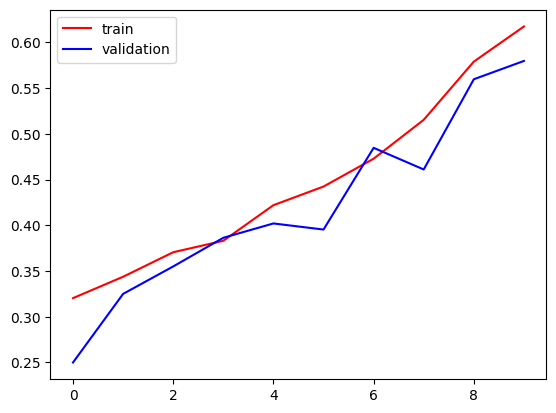

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

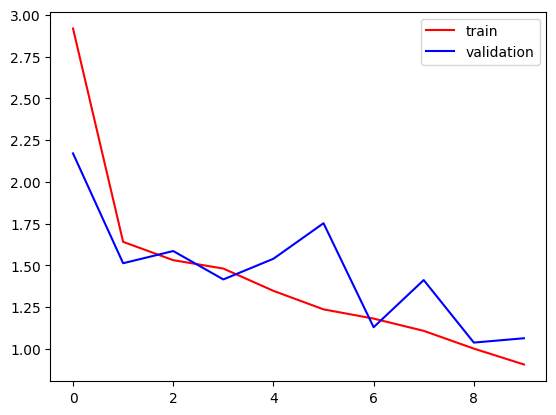

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# lets do some testing on our trained simple cnn
import cv2
test_img= cv2.imread('/content/seg_pred/seg_pred/101.jpg')

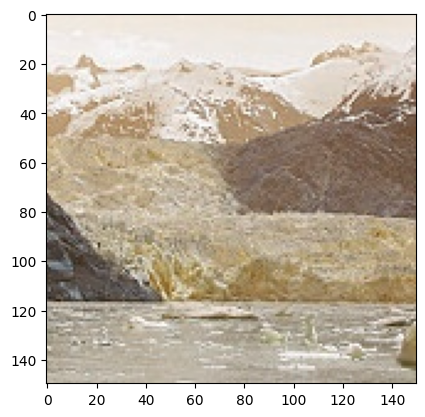

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img.shape

(150, 150, 3)

In [ ]:
test_img= cv2.resize(test_img,(256,256))

In [ ]:
test_input= test_img.reshape(1,256,256,3)

In [ ]:
import numpy as np
predict_result=model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:
predicted_result_idx = np.argmax(predict_result)
predicted_result_idx

np.int64(5)

# Now we will make the cnn  architecture using hyperparameter tuning

In [ ]:
def build_model(hp):
  model= Sequential()
  activation_fx = hp.Choice('activation', values=['relu','tanh'])

  for i in range(hp.Int('num_conv_layers',min_value=1,max_value=3,step=1)):
    if i ==0 :
      model.add(Conv2D(hp.Int('units' + str(i),min_value=24,max_value=64,step=8)
                       ,kernel_size=(3,3),padding='valid',activation=activation_fx,input_shape=(128,128,3)
                       ,kernel_regularizer=tf.keras.regularizers.l2(0.01)))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
    else:
      model.add(Conv2D(hp.Int('units' + str(i),min_value=32,max_value=250,step=48)
                       ,kernel_size=(3,3),padding='valid',activation=activation_fx
                      ,kernel_regularizer = tf.keras.regularizers.l2( l2=0.01)))  # using l2 norm
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

  model.add(Flatten())

  for i in range(hp.Int('num_fc_layers',min_value=1,max_value=4,step=1)):
    model.add(Dense(hp.Int('units_fc' + str(i),min_value=8,max_value=180,step=12),activation=activation_fx,
              kernel_regularizer = tf.keras.regularizers.l2( l2=0.01)))
    model.add(Dropout(0.1))
    # model.add(Dropout(hp.Choice('dropout' + str(i),values=[0.1,0.2,0.3])))

  model.add(Dense(6,activation='softmax'))
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  return model


In [ ]:
tuner = kt.Hyperband(build_model,   # using bayesian optimization for hyperparameter tuning
    objective='val_accuracy',
    max_epochs=30,
    directory='my-dir',
    project_name='cnn2',
    hyperband_iterations=2)

In [ ]:
tuner.search(train_ds,epochs=10,validation_data=validation_ds)

Trial 72 Complete [00h 01m 09s]
val_accuracy: 0.7146666646003723

Best val_accuracy So Far: 0.812666654586792
Total elapsed time: 01h 26m 48s

Search: Running Trial #73

Value             |Best Value So Far |Hyperparameter
relu              |relu              |activation
2                 |3                 |num_conv_layers
32                |56                |units0
1                 |1                 |num_fc_layers
104               |116               |units_fc0
80                |128               |units1
44                |104               |units_fc1
128               |152               |units_fc2
104               |56                |units_fc3
128               |80                |units2
30                |30                |tuner/epochs
10                |10                |tuner/initial_epoch
2                 |3                 |tuner/bracket
2                 |3                 |tuner/round
0069              |0048              |tuner/trial_id

Epoch 11/30
281/281 ━━━━━━━━━━

# we have build the model above so all this hyperparamter tuning is taking more than the required time so it needs to be done afterwords

In [ ]:
# we will now works for data augmentation
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img= image.load_img('/content/seg_pred/seg_pred/10052.jpg',target_size=(200,200))

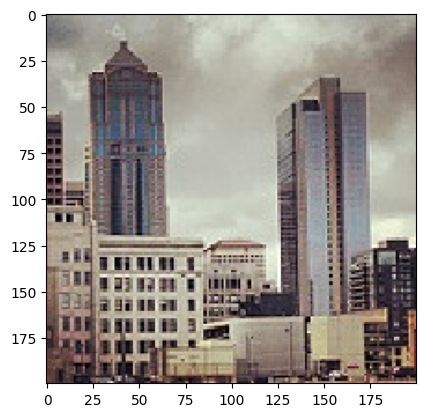

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [ ]:
type(img)

PIL.Image.Image

In [ ]:
img = image.img_to_array(img)

In [ ]:
input_batch=img.reshape(1,200,200,3)
input_batch.shape

(1, 200, 200, 3)

In [ ]:
# to pass one image for data augmentatrion
counter=0

for i in train_datagen.flow(input_batch, batch_size =1,save_to_dir='/content'):
  counter += 1
  if counter==10 :
    break


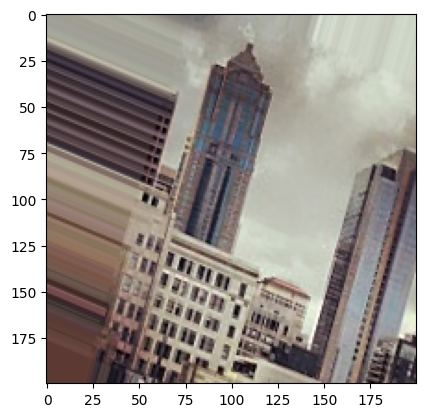

In [ ]:
aug1 = image.load_img('/content/_0_515.png')  # augmented image
plt.imshow(aug1)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # it means after shifting it will fill the pixels same as nearby ones ,there are other options too : reflect (just reflect same as front pixels
    #                 and constant : means it will change the pixel colour to black)
)

test_datagen = ImageDataGenerator(rescale=1./255)  # we don't apply data augmentation on test data

## generators for applying the data augmentation and send the data in batches
train_generator = train_datagen.flow_from_directory(
    '/content/seg_train/seg_train',
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = train_datagen.flow_from_directory(
    '/content/seg_test/seg_test',
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
# first make a simple cnn architecture
batch_size = 32

model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(150,150,3),
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='valid',
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='valid',
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(36,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.fit(
    train_generator,
    steps_per_epoch=14000 // batch_size,  # this means that the model will see all 14k images per epoch in 437 batches(14k// 32) and in next epoch with different augmentation
    epochs=10,
    validation_data=test_generator,# offcource validation data is only rescaled
    validation_steps=800 //batch_size
)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 282ms/step - accuracy: 0.2841 - loss: 8.4472 - val_accuracy: 0.1500 - val_loss: 9.4425
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 333ms/step - accuracy: 0.3101 - loss: 6.7745 - val_accuracy: 0.2713 - val_loss: 7.4436
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 267ms/step - accuracy: 0.3048 - loss: 5.4595 - val_accuracy: 0.1800 - val_loss: 5.7067
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 276ms/step - accuracy: 0.3347 - loss: 4.4581 - val_accuracy: 0.1900 - val_loss: 4.4097
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 284ms/step - accuracy: 0.3564 - loss: 3.8946 - val_accuracy: 0.2512 - val_loss: 3.6789
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 312ms/step - accuracy: 0.3502 - loss: 3.5593 - val_accuracy: 0.3363 - val_loss: 3.5415
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.3625 - loss: 3.5004 - val_accuracy: 0.3413 - val_loss: 3.1565
Epoch 8/10
 5/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4232 - loss: 3.0528

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.3731 - loss: 3.1469 - val_accuracy: 0.4137 - val_loss: 3.0271
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 258ms/step - accuracy: 0.3788 - loss: 3.1385 - val_accuracy: 0.4425 - val_loss: 2.8251
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.3810 - loss: 2.8600 - val_accuracy: 0.3450 - val_loss: 2.9856


flops : no of operations model perform (computational cost )
different pre trained model architectures info : https://medium.com/@daniyalmasoodai/pre-train-cnn-architectures-designs-performance-analysis-and-comparison-802228a5ce92

In [8]:
# lets use a pretrained model to predict our image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np

In [9]:
model = ResNet50(weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
img1= image.load_img('/content/seg_pred/seg_pred/1003.jpg',target_size=(224,224))
img1 = image.img_to_array(img1)
img= np.expand_dims(img1,axis =0)  # batch mein convert kiya
img= preprocess_input(img)


In [20]:
img.shape

(1, 224, 224, 3)

In [21]:
pred = model.predict(img)
print(decode_predictions(pred,top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[('n09428293', 'seashore', np.float32(0.59567046)), ('n09421951', 'sandbar', np.float32(0.33372462)), ('n02894605', 'breakwater', np.float32(0.032357346))]


## just to answer what a cnn see ; thereby vizualizing the cnn filters and feature maps
there is this blog that provide the good intuition that how the cnn works :https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/ ,  can be used for context while dealing with image data

In [22]:
# TRANSFER LEARNING
# done using feature extraction (only fc layers trained )  and fine tuning (fc + some last conv layers are also trained)

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16

conv_base= VGG16(
    weights='imagenet',
    include_top=False,
    input_shape =(150,150,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
conv_base.summary()  # all fc layers are being removed

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model= Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(6,activation='softmax'))

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,638 (64.14 MB)

 Trainable params: 16,813,638 (64.14 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
conv_base.trainable = False

In [11]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/seg_train/seg_train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150,150)
)
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/seg_test/seg_test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150,150)
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [12]:
def process(image,label):
  image= tf.cast(image/255. ,tf.float32)
  return image,label

train_ds = train_ds.map(process)
test_ds = test_ds.map(process)

In [13]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(train_ds,epochs=10,validation_data=test_ds)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - accuracy: 0.7744 - loss: 0.6065 - val_accuracy: 0.8697 - val_loss: 0.3485
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 54s 123ms/step - accuracy: 0.8864 - loss: 0.3043 - val_accuracy: 0.8710 - val_loss: 0.3448
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 83s 125ms/step - accuracy: 0.9094 - loss: 0.2361 - val_accuracy: 0.8727 - val_loss: 0.3426
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 0.9307 - loss: 0.1854 - val_accuracy: 0.8787 - val_loss: 0.3441
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 122ms/step - accuracy: 0.9455 - loss: 0.1446 - val_accuracy: 0.8847 - val_loss: 0.3739
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 119ms/step - accuracy: 0.9618 - loss: 0.1114 - val_accuracy: 0.8563 - val_loss: 0.4701
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 54s 123ms/step - accuracy: 0.9647 - loss: 0.0980 - val_accuracy: 0.8493 - val_loss: 0.6083
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 54s 123ms/step - accuracy: 0.9673 - loss: 0

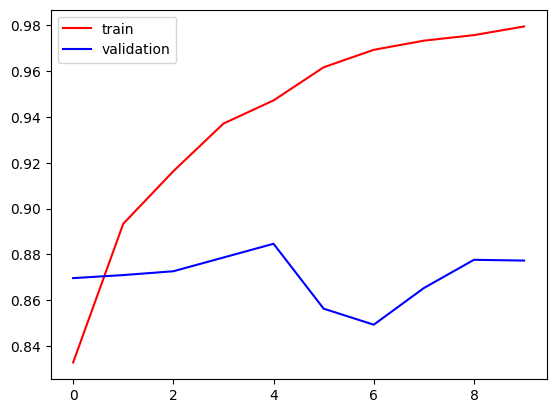

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

now we will do transfer learning with data augmentation


In [6]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img

In [23]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/seg_train/seg_train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '/content/seg_test/seg_test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [24]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 112s 247ms/step - accuracy: 0.9022 - loss: 0.3107 - val_accuracy: 0.8597 - val_loss: 0.4467
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 105s 240ms/step - accuracy: 0.9126 - loss: 0.2462 - val_accuracy: 0.8737 - val_loss: 0.3952
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 104s 236ms/step - accuracy: 0.9230 - loss: 0.2069 - val_accuracy: 0.8843 - val_loss: 0.3377
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 104s 236ms/step - accuracy: 0.9300 - loss: 0.1886 - val_accuracy: 0.8720 - val_loss: 0.3718
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 104s 236ms/step - accuracy: 0.9284 - loss: 0.1834 - val_accuracy: 0.8740 - val_loss: 0.3727
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 104s 236ms/step - accuracy: 0.9315 - loss: 0.1812 - val_accuracy: 0.8880 - val_loss: 0.3610
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 106s 241ms/step - accuracy: 0.9423 - loss: 0.1526 - val_accuracy: 0.8833 - val_loss: 0.3712
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 103s 234ms/step - accuracy: 0.9441 -

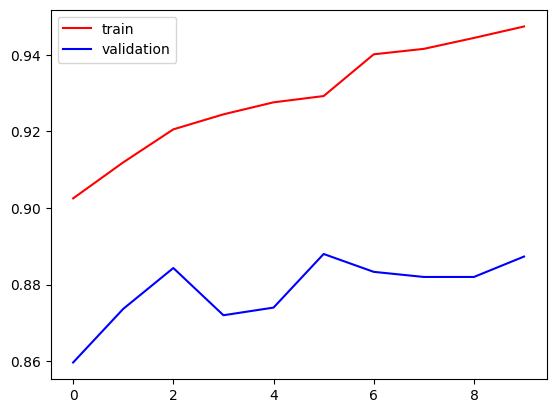

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

## now we will perform finetuning on the pre trained model .

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

conv_base=VGG16(
    weights= 'imagenet',
    include_top= False,
    input_shape=(150,150,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [7]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [17]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(6,activation='softmax'))

In [18]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/seg_train/seg_train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150,150)
)
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/seg_test/seg_test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150,150)
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [19]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = test_ds.map(process)

In [20]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [21]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 87s 174ms/step - accuracy: 0.7340 - loss: 0.7707 - val_accuracy: 0.8397 - val_loss: 0.4321
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 60s 136ms/step - accuracy: 0.9001 - loss: 0.2947 - val_accuracy: 0.8903 - val_loss: 0.3017
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 60s 136ms/step - accuracy: 0.9225 - loss: 0.2242 - val_accuracy: 0.8920 - val_loss: 0.3018
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 61s 140ms/step - accuracy: 0.9381 - loss: 0.1796 - val_accuracy: 0.8977 - val_loss: 0.2853
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 60s 137ms/step - accuracy: 0.9561 - loss: 0.1379 - val_accuracy: 0.9047 - val_loss: 0.2806
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 60s 137ms/step - accuracy: 0.9664 - loss: 0.1052 - val_accuracy: 0.9047 - val_loss: 0.2974
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 60s 137ms/step - accuracy: 0.9733 - loss: 0.0806 - val_accuracy: 0.9087 - val_loss: 0.2929
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 61s 139ms/step - accuracy: 0.9827 - loss: 0

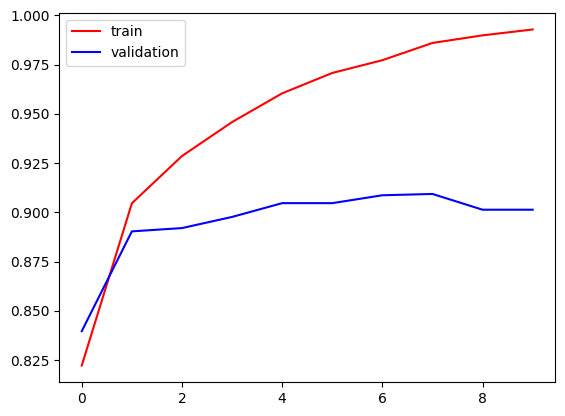

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()